In [2]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.spatial import distance

In [3]:
DATA_PATH = 'data_test/kidney_analysis/'

In [4]:
ct_dicom = dicom.read_file(DATA_PATH + "1-162.dcm")
ct_img = ct_dicom.pixel_array
print(ct_img.shape)
print(ct_img.dtype)

(512, 512)
int16


In [5]:
kidney_roi = io.imread(DATA_PATH + 'KidneyROI.png')
# convert to boolean image
kidney_mask = kidney_roi > 0
kidney_values = ct_img[kidney_mask]

Aorta_roi = io.imread(DATA_PATH + 'AortaROI.png')
# convert to boolean image
Aorta_mask = Aorta_roi > 0
Aorta_values = ct_img[Aorta_mask]

liver_roi = io.imread(DATA_PATH + 'LiverROI.png')
# convert to boolean image
liver_mask = liver_roi > 0
liver_values = ct_img[liver_mask]

In [6]:
threshold_kid_liver = (np.mean(kidney_values) + np.mean(liver_values)) /2
threshold_kid_Aorta = (np.mean(kidney_values) + np.mean(Aorta_values)) /2
print(threshold_kid_liver, threshold_kid_Aorta)

135.53619417264818 196.7035801627044


In [12]:
def kidney_finder(ct_img, ROI = 'SpleenROI.png'):
    #spleen_roi = io.imread(in_dir + ROI)
    # convert to boolean image
    #spleen_mask = spleen_roi > 0
    #spleen_values = ct_img[spleen_mask]


    t_1 = threshold_kid_liver #np.mean(spleen_values) + 2* np.std(spleen_values)
    t_2 = threshold_kid_Aorta #np.mean(spleen_values) - 2* np.std(spleen_values)

    kidney_estimate = (ct_img > t_2) & (ct_img < t_1)

    footprint = disk(2)
    closed = binary_closing(kidney_estimate, footprint)

    footprint = disk(6)
    opened = binary_opening(closed, footprint)

    label_img = measure.label(opened)
    #plt.imshow(label_img)
    #plt.show()
    min_area = 500
    max_area = 4000
    max_peri = 900
    min_peri = 100
    max_circ = 1.2
    min_circ = 0.6
    region_props = measure.regionprops(label_img)
    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the areas that do not fit our criteria
        circularity = 4*np.pi*region.area/region.perimeter**2
        if region.area > max_area or region.area < min_area or region.perimeter > max_peri or region.perimeter < min_peri or circularity > max_circ or circularity < min_circ:
                # set the pixels in the invalid areas to background
                for cords in region.coords:
                    label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    i_area = label_img_filter > 0



    return i_area


In [13]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

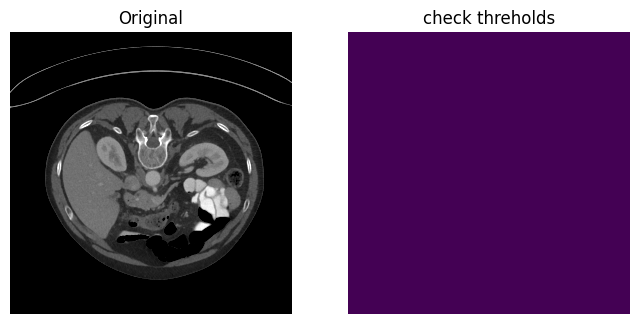

In [14]:
test = kidney_finder(ct_img=ct_img, ROI = DATA_PATH + 'KidneyROI.png')
show_comparison(ct_img, test, 'check threholds')
show_comparison(ct_img, test, 'check threholds')
